In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

In [ ]:
### Installation of the necessary packages

#general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import LabelEncoder

#classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


#other imports
from worcliver.load_data import load_data

### Loading the data
data = load_data()

### Set the number samples for the training set (80%) and test set (20%)
amount_in_training = round(len(data.index)*0.8)
amount_in_test = round(len(data.index)*0.2)

#split the data into training data and test data in order to make sure choices are only based on training set
training_data, test_data = model_selection.train_test_split(data, test_size=(amount_in_test) / len(data), random_state=42)

#checking the lengths of training and test set
print(f'Training + validation: {len(training_data)} samples + {len(test_data)} samples.')
print(f'Total number of dataset samples: {len(training_data)+len(test_data)}')

### Check number of asa: only on the training set!
print(f'The number of training set samples: {len(training_data.index)}')
print(f'The number of columns in training set: {len(training_data.columns)}')

training_data_df = pd.DataFrame(training_data) 

# Find number of categorical and numerical features in training set 
cat_cols = training_data_df.select_dtypes(include=["object"]).columns
num_cols = training_data_df.select_dtypes(include=["number"]).columns
print(f"categorical columns: {len(cat_cols)}")
print(f'numerical columns: {len(num_cols)}')

# Find samples without any variation
no_variation_samples = 0
for sample in training_data.index:
    data_sample = training_data.drop(columns=['label']) # first drop the label 
    if data_sample.loc[sample].max() == data_sample.loc[sample].min(): #check for variation
        no_variation_samples += 1
print(f'samples with no variation: {no_variation_samples}')

# Find samples without any variation       
no_variation_col = 0
for feature in training_data.columns:
    if training_data[feature].max() == training_data[feature].min(): #check for variation
        no_variation_col += 1
print(f'features with no variation: {no_variation_col}')

# Check the number of malignant and beningn samples in the training dataset
label = training_data[['label']]
malignant_count = (label == "malignant").sum()
benign_count = (label == "benign").sum()

print(f'Class Distribution: malignant {malignant_count} and benign {benign_count}')


Training + validation: 149 samples + 37 samples.
Total number of dataset samples: 186
The number of training set samples: 149
The number of columns in training set: 494
categorical columns: 1
numerical columns: 493
samples with no variation: 0
features with no variation: 19
Class Distribution: malignant label    76
dtype: int64 and benign label    73
dtype: int64


## Preprocessing
The function definitions of the functions used for preprocessing.

In [4]:
### Some functions for the preprocessing of the data, decisions made based on training set results
def determining_labels(df):
    """Extracts and binarizes labels, and removes the label column from the input DataFrame."""
    
    if 'label' not in df.columns:
        raise KeyError("Expected 'label' column not found in DataFrame.") 

    # Copy label column safely
    label_column = df['label'].copy()

    # Drop label from the input DataFrame without modifying the original
    df.drop(columns=['label'], inplace=True)

    # Convert to binary labels to construct the classifiers
    label_binary = label_column.map({'malignant': 1, 'benign': 0})
    return label_binary

def handling_missing_data(training_data):
    '''Searches for NaN in the training data, and replaces them with the mean value, 
    returns the training data without missing NaNs'''
    data_training = pd.DataFrame(training_data) 

    #if missing data is stored as NaN, replace with the mean
    nan_check = data_training.isna()
    nan_counts = nan_check.sum() #count number of NaNs 
    missing_data_features = nan_counts[nan_counts > 0].index.tolist()

    # loop over the features with missing data and replace the value with the mean 
    for feature in missing_data_features:
        mean_value = data_training[feature].mean()
        data_training[feature].fillna(mean_value, inplace=True)
    
    # N.B. if missing data is stored as 0, don't handle this as missing data: values in Radiomics can also be determined as 0

    return data_training

def shapiro_wilk_testing(data_training):
    '''function definition'''
    shapiro_results = {}
    no_variation = 0
    features_no_variation = []

    for feature in data_training.columns:
        if data_training[feature].max() == data_training[feature].min(): #checks if the feature has zero variance
            shapiro_results[feature] = None  #skipping the feature when there is no variation
            no_variation += 1 #count the number of features without variation 
            features_no_variation.append(feature)
    return features_no_variation #returns the features without variation
  
def delete_no_varation(data_training, features_no_variation):
    '''Removes all features from the training data that have no variance'''
    data_training_clean = data_training.drop(columns=features_no_variation)
    return data_training_clean

def standardize_data(data_training_clean):
    '''function definition'''
    scaler = preprocessing.StandardScaler()
    data_training_standardized = scaler.fit_transform(data_training_clean)
    data_training_standardized_df = pd.DataFrame(data_training_standardized, columns=data_training_clean.columns)
    return data_training_standardized_df


## Feature extraction
The function definitions of the functions used for feature extraction.

In [5]:
### Univariate selection

def univariate_feature_selection(data_training_normalized_df):
    '''function definition'''
    corr_matrix = data_training_normalized_df.corr()

    #step 1: calculate the correlation and associated p-value for every feature-pair
    corr_matrix = pd.DataFrame(index=data_training_normalized_df.columns, columns=data_training_normalized_df.columns, dtype=float)
    pval_matrix = pd.DataFrame(index=data_training_normalized_df.columns, columns=data_training_normalized_df.columns, dtype=float)

    for col1 in data_training_normalized_df.columns:
        for col2 in data_training_normalized_df.columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
                pval_matrix.loc[col1, col2] = 0.0
            else:
                r, p = stats.pearsonr(data_training_normalized_df[col1], data_training_normalized_df[col2])
                corr_matrix.loc[col1, col2] = r
                pval_matrix.loc[col1, col2] = p


    #step 2: loop through all the feature pairs and determine which ones have a high correlation and low p-value
    threshold = 0.9
    p_threshold = 0.05

    to_drop = set()

    for i, col1 in enumerate(data_training_normalized_df.columns):
        for j, col2 in enumerate(data_training_normalized_df.columns):
            if i >= j:
                continue
            r = corr_matrix.loc[col1, col2]
            p = pval_matrix.loc[col1, col2]

            if abs(r) > threshold and p < p_threshold:
                if col1 not in to_drop and col2 not in to_drop:
                    col_to_drop = col2
                    to_drop.add(col_to_drop)

    print("Dropped features due to high correlation:")
    print(to_drop)

    #step 3: drop one of the features in a feature pair with high correlation and low p-value
    data_training_reduced = data_training_normalized_df.drop(columns=to_drop)

    print(f"Size of new training data set is:{data_training_reduced.shape}; Old was: {data_training_normalized_df.shape}")
    return data_training_reduced


def lasso_feature_selection(data_training_reduced, label_training_binary):
    '''function definition'''
    label_training_array = label_training_binary.values.flatten()

    #step 1: perform Lasso with cross-validation for 50 values of alpha on 10 segments over 10.000 iterations
    lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 100), cv=10, max_iter=10000)  
    lasso_cv.fit(data_training_reduced, label_training_array)

    #step 2: find the best alpha value
    best_alpha = lasso_cv.alpha_
    print(f"Optimal Alpha: {best_alpha}")

    #step 3: fit LASSO again with optimal alpha
    lasso_opt = Lasso(alpha=best_alpha)
    lasso_opt.fit(data_training_reduced, label_training_array)

    #step 4: get the features of interest, and only extract those
    selected_features = data_training_reduced.columns[lasso_opt.coef_ != 0]
    print(f"Number of selected features: {len(selected_features)}")
    print(f"Final Selected Features: {list(selected_features)} ")

    training_data_selected = data_training_reduced[selected_features]
    training_data_selected_df = pd.DataFrame(training_data_selected)

    print(f"Size of new training data set is:{training_data_selected.shape}")
    return training_data_selected_df

## Classifiers

### K-Nearest Neighbours
Function definition used for the KNN classifier.

In [6]:
def KNN_classifier(training_data_selected_df, label_training_binary):


    label_training_array = label_training_binary.values.flatten()
    input_knn = training_data_selected_df

    x_train_KNN = input_knn
    y_train_KNN = label_training_array

    x_train_KNN = np.ascontiguousarray(x_train_KNN.values, dtype=np.float64)

    param_grid = {
        'n_neighbors': list(range(1, 31)),
    }   

    # Initialize the classifier
    knn = KNeighborsClassifier()
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    # GridSearchCV to find the best k
    grid_search = model_selection.GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1, return_train_score=True, error_score='raise')

    # Fit model
    grid_search.fit(x_train_KNN, y_train_KNN)

    # Convert cv_results_ to a DataFrame for easier manipulation
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Vind alle individuele fold score kolommen
    fold_columns = [col for col in results_df.columns if col.startswith("split") and col.endswith("_test_score")]

    # Aantal folds
    n_folds = len(fold_columns)

    # Functie om CI te berekenen per rij
    def compute_confidence_interval(row):
        scores = row[fold_columns].values
        mean = np.mean(scores)
        std = np.std(scores, ddof=1)  # sample std dev
        ci_halfwidth = stats.norm.ppf(0.975) * std / np.sqrt(n_folds)
        return pd.Series({
            'mean_score': mean,
            'std_score': std,
            'ci_lower': mean - ci_halfwidth,
            'ci_upper': mean + ci_halfwidth
        })

    # Pas toe op elke rij (elke modelconfiguratie)
    ci_df = results_df.apply(compute_confidence_interval, axis=1)

    # Build a DataFrame with all the relevant info
    final_df = pd.concat([
        results_df[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']],
        ci_df
    ], axis=1)

    # Print de top 5 met hoogste mean_score
    top_models = final_df.sort_values(by='mean_score', ascending=False).head(5)
    print(top_models)

    #retraining the model with the top parameters
    top_params_KNN = top_models.iloc[0]['params']
    final_KNN_model = KNeighborsClassifier(**top_params_KNN)
    final_KNN_model.fit(x_train_KNN, y_train_KNN)

    return final_KNN_model

### Random forest
Function definition used for the random forest classifier.

In [7]:
def random_forest_classifier(training_data_selected_df, label_training_binary):
    label_training_array = label_training_binary.values.flatten()
    input_random_forest = training_data_selected_df
    
    X_train_RF = input_random_forest
    y_train_RF = label_training_array

    X_train_RF = np.ascontiguousarray(X_train_RF.values, dtype=np.float64)

    param_grid_RF = {
        'n_estimators': [110, 115, 120],                     #trees
        'max_depth': [5, 8, 13],                         #maximum depth
        'bootstrap': [True],                     #bootstrap on or off >> moet dus True of False zijn, maar aangezien er altijd True kwam dat nu even gelaten voor snelheid runnen
        'min_samples_split': [2, 3, 4, 5],                    #minimum samples required to split
        'min_samples_leaf': [1, 2, 3],                  #minimum samples wat je uiteindelijk in een leaf overhoudt 
        'max_features': ['sqrt', 'log2'],                       #controls the number of features selected, can also try log2 
        'min_impurity_decrease': [0.00001, 0.000005, 0.00002]   #controls the minimum amount of impurity reduction required for a split to be created    
    }

    random_forest = RandomForestClassifier(random_state=42)

    #de grid search naar de beste hyperparameters
    grid_search_RF = model_selection.GridSearchCV(random_forest, param_grid_RF, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)

    # Fit GridSearchCV to the data
    grid_search_RF.fit(X_train_RF, y_train_RF)

    #find the accuracies per fold
    results_df_RF = pd.DataFrame(grid_search_RF.cv_results_)

    # Vind alle individuele fold score kolommen
    fold_columns_RF = [col for col in results_df_RF.columns if col.startswith("split") and col.endswith("_test_score")]

    # Aantal folds
    n_folds_RF = len(fold_columns_RF)

    # Functie om CI te berekenen per rij
    def compute_confidence_interval_RF(row):
        scores = row[fold_columns_RF].values
        mean = np.mean(scores)
        std = np.std(scores, ddof=1)  # sample std dev
        ci_halfwidth = stats.norm.ppf(0.975) * std / np.sqrt(n_folds_RF)
        return pd.Series({
            'mean_score': mean,
            'std_score': std,
            'ci_lower': mean - ci_halfwidth,
            'ci_upper': mean + ci_halfwidth
        })

    # Pas toe op elke rij (elke modelconfiguratie)
    ci_RF = results_df_RF.apply(compute_confidence_interval_RF, axis=1)

    # Combineer met de parameterinstellingen
    final_RF = pd.concat([results_df_RF['params'], ci_RF], axis=1)

    # Print de top 5 met hoogste mean_score
    top_models_RF = final_RF.sort_values(by='mean_score', ascending=False).head(5)

    pd.set_option('display.max_colwidth', None)
    print(top_models_RF)

    #retraining the model with the top parameters
    top_params_RF = top_models_RF.iloc[0]['params']
    final_RF_model = RandomForestClassifier(**top_params_RF, random_state=42)
    final_RF_model.fit(X_train_RF, y_train_RF)

    return final_RF_model


### Support vector machine
Function definition used for the support vector machine classifier.

In [8]:
def SVM_classifier(training_data_selected_df, label_training_binary):
    label_training_array = label_training_binary.values.flatten()
    input_SVM = training_data_selected_df

    X_train_SVM = input_SVM
    y_train_SVM = label_training_array

    X_train_SVM = np.ascontiguousarray(X_train_SVM.values, dtype=np.float64)

    param_grid_SVM = {
        'kernel': ['linear', 'poly', 'rbf'],        # kernel-types
        'C': [0.01, 0.1, 1, 2, 3, 5, 10, 100],      # Expand the range of C values
        'gamma': ['scale', 'auto', 0.01, 0.05, 0.1, 0.2, 0.5], # Add more gamma values
        'degree': [1, 3, 5, 10, 12, 15],            # Add more degree values for polynomial kernel
        'coef0': [0.0, 0.01, 0.5, 1, 2]             # Extend coef0 range
    }

    SVM_model = SVC()

    #de grid search naar de beste hyperparameters
    grid_search_SVM = model_selection.GridSearchCV(SVM_model, param_grid_SVM, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)

    # Fit GridSearchCV to the data
    grid_search_SVM.fit(X_train_SVM, y_train_SVM)

    #find the accuracies per fold
    results_df_SVM = pd.DataFrame(grid_search_SVM.cv_results_)

    # Vind alle individuele fold score kolommen
    fold_columns_SVM = [col for col in results_df_SVM.columns if col.startswith("split") and col.endswith("_test_score")]

    # Aantal folds
    n_folds_SVM = len(fold_columns_SVM)

    # Functie om CI te berekenen per rij
    def compute_confidence_interval_SVM(row):
        scores = row[fold_columns_SVM].values
        mean = np.mean(scores)
        std = np.std(scores, ddof=1)  # sample std dev
        ci_halfwidth = stats.norm.ppf(0.975) * std / np.sqrt(n_folds_SVM)
        return pd.Series({
            'mean_score': mean,
            'std_score': std,
            'ci_lower': mean - ci_halfwidth,
            'ci_upper': mean + ci_halfwidth
        })

    # Pas toe op elke rij (elke modelconfiguratie)
    ci_SVM = results_df_SVM.apply(compute_confidence_interval_SVM, axis=1)

    # Combineer met de parameterinstellingen
    final_SVM = pd.concat([results_df_SVM['params'], ci_SVM], axis=1)

    # Print de top 5 met hoogste mean_score
    top_models_SVM = final_SVM.sort_values(by='mean_score', ascending=False).head(5)
    pd.set_option('display.max_colwidth', None)
    print(top_models_SVM)

    #retraining the model with the top parameters
    top_params_SVM = top_models_SVM.iloc[0]['params']
    final_SVM_model = SVC(**top_params_SVM)
    final_SVM_model.fit(X_train_SVM, y_train_SVM)

    return final_SVM_model

### Creating the machine learning models and testing it

In [ ]:
### Loading the data
data = load_data()

### Division into training and test
amount_in_training = round(len(data.index)*0.8)
amount_in_test = round(len(data.index)*0.2)

results = []
all_selected_features = []
stored_models = {
        "KNN": [],
        "KNN_LASSO": [],
        "RF": [],
        "RF_LASSO": [],
        "SVM": [],
        "SVM_LASSO": []
        }
roc_data = {
    "KNN": [],
    "RF": [],
    "SVM": [],
    "KNN + LASSO": [],
    "RF + LASSO": [],
    "SVM + LASSO": []
}

for i in range(1):
    # Work with a *copy* of the full dataset each time
    full_data = data.copy()

    training_data, test_data = model_selection.train_test_split(
        full_data, test_size=(amount_in_test) / len(full_data), random_state=np.random.randint(10000)
    )
    
    ### Preprocessing the training data
    label_training_binary = determining_labels(training_data)
    data_training = handling_missing_data(training_data)
    features_no_variation = shapiro_wilk_testing(data_training)
    data_training_clean = delete_no_varation(data_training, features_no_variation)
    data_training_normalized_df = standardize_data(data_training_clean)

    ### Preprocessing the test data
    label_test_binary = determining_labels(test_data)
    data_test = handling_missing_data(test_data)
    data_test_clean = delete_no_varation(data_test, features_no_variation)
    data_test_normalized_df = standardize_data(data_test_clean)

    ### Preprocessing all the data together (needed for learning curves)
    label_binary = determining_labels(full_data)
    full_data_clean = handling_missing_data(full_data)
    data_clean = delete_no_varation(full_data_clean, features_no_variation)
    data_normalized_df = standardize_data(data_clean)

    ### Feature selection
    data_training_univariate = univariate_feature_selection(data_training_normalized_df)
    training_data_selected_df = lasso_feature_selection(data_training_univariate, label_training_binary)
    selected_features = training_data_selected_df.columns.tolist()

    all_selected_features.append(selected_features)

    ### Training the classifiers
    final_KNN_model_LASSO = KNN_classifier(training_data_selected_df, label_training_binary)
    final_RF_model_LASSO = random_forest_classifier(training_data_selected_df, label_training_binary)
    final_SVM_model_LASSO = SVM_classifier(training_data_selected_df, label_training_binary)

    final_KNN_model = KNN_classifier(data_training_univariate, label_training_binary)
    final_RF_model = random_forest_classifier(data_training_univariate, label_training_binary)
    final_SVM_model = SVM_classifier(data_training_univariate, label_training_binary)

    #accuracy of the prediction of the test set
    y_test = label_test_binary.values.flatten()
    X_test_LASSO = data_test_normalized_df.reset_index(drop=True)[training_data_selected_df.columns]
    X_test_LASSO = np.ascontiguousarray(X_test_LASSO.values, dtype=np.float64)
    X_test = data_test_normalized_df.reset_index(drop=True)[data_training_univariate.columns]
    X_test = np.ascontiguousarray(X_test.values, dtype=np.float64)

    models_info = {
    "KNN": (final_KNN_model, X_test),
    "RF": (final_RF_model, X_test),
    "SVM": (final_SVM_model, X_test),
    "KNN + LASSO": (final_KNN_model_LASSO, X_test_LASSO),
    "RF + LASSO": (final_RF_model_LASSO, X_test_LASSO),
    "SVM + LASSO": (final_SVM_model_LASSO, X_test_LASSO)}

    result_row = []
    for label, (model, X_input) in models_info.items():
    # Accuracy
        y_pred = model.predict(X_input)
        acc = accuracy_score(y_test, y_pred)

    # Scoring for ROC and AUC
        if hasattr(model, "predict_proba"):
           y_score = model.predict_proba(X_input)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_input)
        else:
            y_score = model.predict(X_input)  # fallback

    # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_score)
        model_auc = auc(fpr, tpr)

    # Store for final results table
        result_row.extend([acc, model_auc])

    # Store for plotting
        roc_data[label].append((fpr, tpr))

    stored_models["KNN"].append(final_KNN_model)
    stored_models["KNN_LASSO"].append(final_KNN_model_LASSO)
    stored_models["RF"].append(final_RF_model)
    stored_models["RF_LASSO"].append(final_RF_model_LASSO)
    stored_models["SVM"].append(final_SVM_model)
    stored_models["SVM_LASSO"].append(final_SVM_model_LASSO)

    results.append(result_row)
    
# Convert to numpy array for easier handling
results_array = np.array(results)

# Optional: show as DataFrame for readability
columns = [
    "KNN_Acc", "KNN_AUC", "RF_Acc", "RF_AUC", "SVM_Acc", "SVM_AUC",
    "KNN_LASSO_Acc", "KNN_LASSO_AUC", "RF_LASSO_Acc", "RF_LASSO_AUC", "SVM_LASSO_Acc", "SVM_LASSO_AUC"
]
results_df = pd.DataFrame(results_array, columns=columns)
print(results_df)

Dropped features due to high correlation:
{'PREDICT_original_tf_GLCM_contrastd3.0A0.79', 'PREDICT_original_tf_GLCMMS_dissimilarityd3.0A0.79std', 'PREDICT_original_tf_Gabor_quartile_range_F0.2_A1.57', 'PREDICT_original_vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_tf_Gabor_std_F0.05_A0.0', 'PREDICT_original_tf_Gabor_range_F0.2_A2.36', 'PREDICT_original_phasef_monogenic_median_WL3_N5', 'PREDICT_original_tf_GLCMMS_homogeneityd1.0A1.57mean', 'PREDICT_original_tf_GLCMMS_ASMd3.0A2.36mean', 'PREDICT_original_tf_Gabor_std_F0.5_A0.79', 'PREDICT_original_tf_GLCMMS_contrastd3.0A0.0std', 'PREDICT_original_tf_GLCMMS_energyd1.0A0.79std', 'PREDICT_original_phasef_phasesym_std_WL3_N5', 'PREDICT_original_tf_GLCMMS_dissimilarityd3.0A1.57mean', 'PREDICT_original_tf_GLCMMS_homogeneityd1.0A0.0mean', 'PREDICT_original_tf_Gabor_range_F0.05_A0.79', 'PREDICT_original_tf_GLCM_energyd3.0A2.36', 'PREDICT_original_tf_Gabor_min_F0.5_A1.57', 'PREDICT_original_tf_LBP_skewness_R15_P36', 'PREDIC

### plotten ROC curves

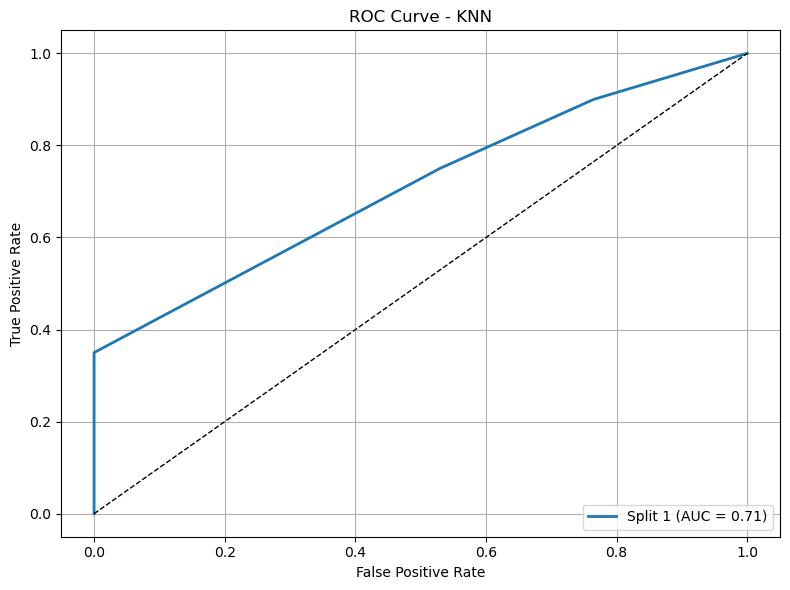

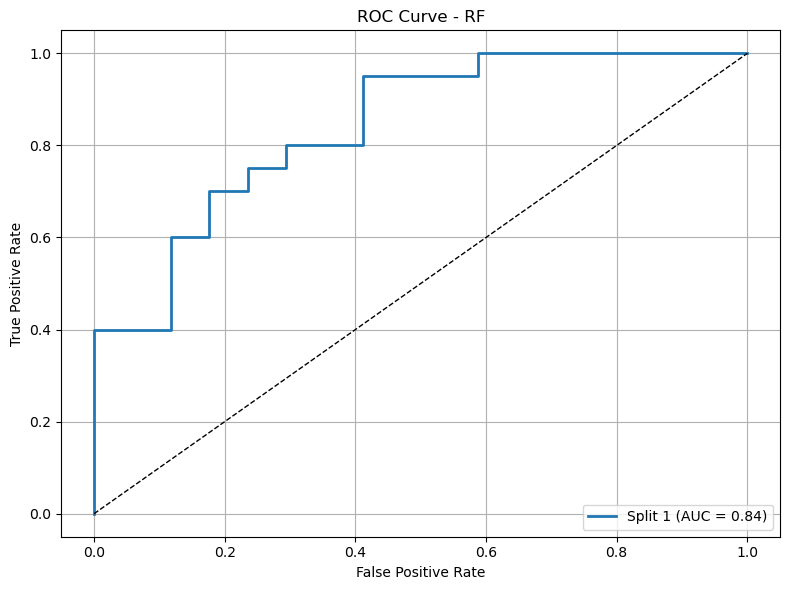

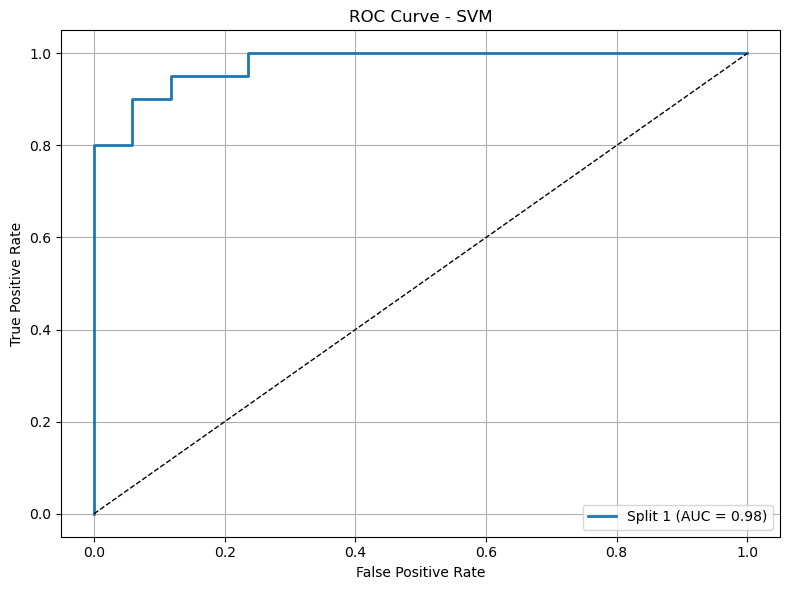

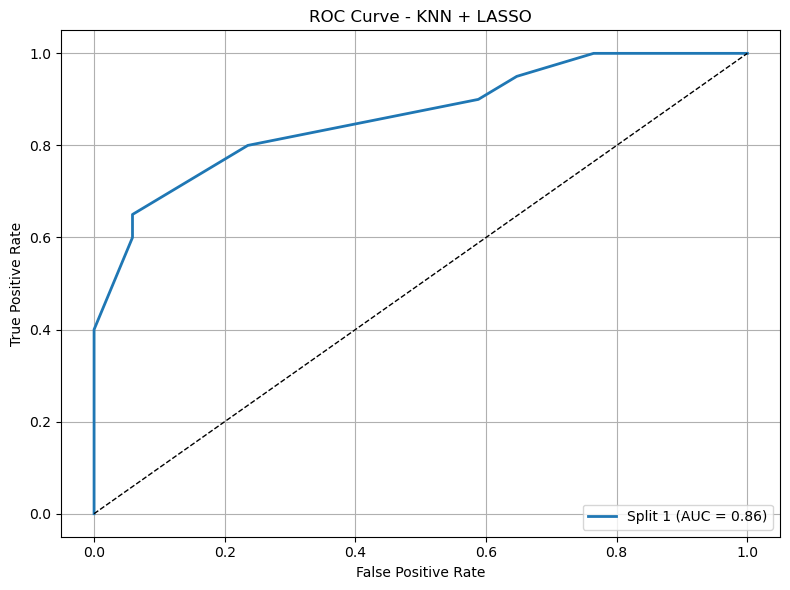

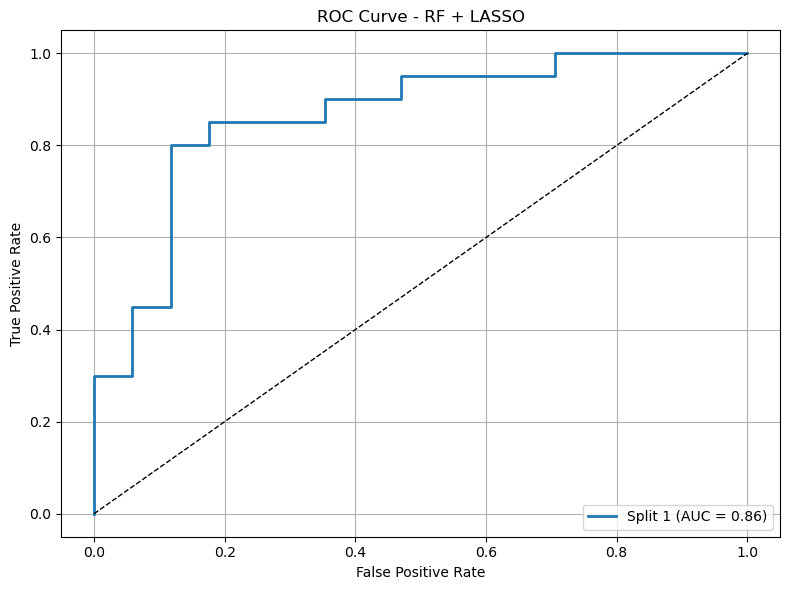

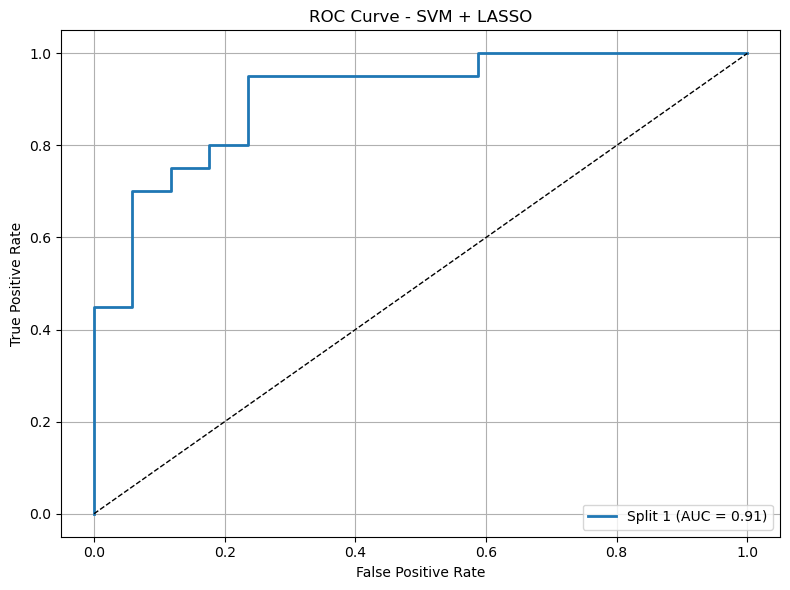

In [37]:
# === Plotting ROC curves ===
from sklearn.metrics import auc

for label, curves in roc_data.items():
    plt.figure(figsize=(8, 6))
    for i, (fpr, tpr) in enumerate(curves):
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Split {i+1} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title(f'ROC Curve - {label}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Learning curve

In [ ]:
model_groups = [
    ("KNN", "KNN_AUC", "KNN_LASSO_AUC"),
    ("RF", "RF_AUC", "RF_LASSO_AUC"),
    ("SVM", "SVM_AUC", "SVM_LASSO_AUC")
]

# Lijst om resultaten op te slaan
best_auc_results = []

# Loop per modelgroep
for group_name, column, column_lasso in model_groups:
    highest_auc = -1
    best_model = ""
    best_run = -1

    # Loop door de rijen
    for i, (auc, auc_lasso) in enumerate(zip(results_df[column], results_df[column_lasso])):
        if auc >= auc_lasso:
            auc = auc
            model = group_name
        else:
            auc = auc_lasso
            model = group_name + "_LASSO"

        if auc > highest_auc:
            highest_auc = auc
            best_model = model
            best_run = i

    best_auc_results.append({
        "Classifier type": group_name,
        "Best feature selection": best_model,
        "Best AUC": highest_auc,
        "Run Index": best_run
    })

# Omzetten naar DataFrame
best_auc_df = pd.DataFrame(best_auc_results)
print(best_auc_df)

models_df = pd.DataFrame(stored_models)

best_models = {}
features_best_model ={}
for _, row in best_auc_df.iterrows():
    group       = row["Classifier type"]    # bv. "KNN"
    variant     = row["Best feature selection"]   # bv. "KNN" of "KNN_LASSO"
    run_idx     = int(row["Run Index"])# bv. 0..4
    print(run_idx)
    # Let op: variant moet exact een kolomnaam in models_df zijn
    best_models[group] = models_df.loc[run_idx, variant]
    features_best_model[group] = all_selected_features[run_idx]

# Voorbeeld van gebruik
best_KNN_model = best_models["KNN"]
features_best_KNN_model = features_best_model["KNN"]

best_RF_model = best_models["RF"]
features_best_RF_model = features_best_model["RF"]

best_SVM_model = best_models["SVM"]
features_best_SVM_model = features_best_model["SVM"]

print(best_KNN_model)
print(best_RF_model)
print(best_SVM_model)

### Preprocessing all the data together (needed for learning curves)
label_binary_lc = determining_labels(data)
full_data_clean_lc = handling_missing_data(data)
data_clean_lc = delete_no_varation(full_data_clean_lc, features_no_variation)
data_normalized_df_lc = standardize_data(data_clean_lc)

#input data
input_lc_KNN = data_normalized_df_lc[features_best_KNN_model]
input_lc_KNN = pd.DataFrame(input_lc_KNN)

input_lc_RF = data_normalized_df_lc[features_best_RF_model]
input_lc_RF = pd.DataFrame(input_lc_RF)

input_lc_SVM = data_normalized_df_lc[features_best_SVM_model]
input_lc_SVM = pd.DataFrame(input_lc_SVM)

# Define sizes of the training set to use (10 steps from 10% to 100%)
train_sizes = np.linspace(0.1, 1.0, 10)

# Get learning curve scores
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_SVM_model,
    X=input_lc_SVM, # complete dataset after complete preprocessing
    y=label_binary_lc, # labels of the complete dataset 
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_times=False
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.title(f"Learning Curve for {model.__class__}")
plt.plot(train_sizes, train_mean, 'o-', color="red", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="red")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Test set score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="green")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.grid(True)
plt.legend(loc="best")
plt.ylim(0.3, 1.05)
plt.tight_layout()
plt.show()
